# Ant Colony Optimization Algorithm: Bin-Packing Problem

Ce code implémente un algorithme d'optimisation par colonie de fourmis (ACO, Ant Colony Optimization) pour résoudre le problème du bin-packing. L'objectif est de trouver la meilleure façon de répartir des objets de poids différents dans des conteneurs (bins) de taille égale, en minimisant la différence de poids entre le conteneur le plus lourd et le plus léger.

Voici une explication détaillée du code :

1. La fonction `ACO` prend en entrée le nombre de conteneurs, la liste des poids des objets, le nombre de chemins de fourmis, le taux d'évaporation des phéromones, le nombre d'évaluations de fitness et le nombre d'essais.

2. Pour chaque essai, des phéromones aléatoires sont initialisées sur tous les chemins possibles.

3. Ensuite, pour un certain nombre d'évaluations de fitness, les chemins des fourmis sont simulés :
   - La fonction `navigate_path` détermine le chemin d'une fourmi en se basant sur les probabilités calculées à partir des phéromones.
   - La fitness de chaque chemin est calculée comme la différence entre le poids maximum et minimum des conteneurs.

4. Après chaque évaluation de fitness, les phéromones sont mises à jour :
   - Les chemins les plus courts (meilleure fitness) reçoivent plus de phéromones.
   - Les phéromones s'évaporent progressivement avec un certain taux (fonction `evaporate`).

5. Après tous les essais, le meilleur chemin (fitness minimale) est retourné.

Les fonctions supplémentaires sont :

- `navigate_path` : Simule le chemin d'une fourmi en choisissant les conteneurs en fonction des probabilités calculées à partir des phéromones.
- `evaporate` : Applique le taux d'évaporation sur les phéromones de chaque chemin.


In [ ]:
def read_input_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        num_elements = int(lines[0])
        bin_capacity = int(lines[1])
        item_weights = [int(weight) for weight in lines[2:]]

    return num_elements, bin_capacity, item_weights

if __name__ == "__main__":
    # Read input from file
    num_elements, bin_capacity, item_weights = read_input_from_file("BPP_50_50_0.1_0.7_0.txt")

    # Parameters for ACO algorithm
    bins = 5  # Number of bins (you can adjust as needed)
    paths = 10  # Number of ant paths (you can adjust as needed)
    evap_rate = 0.1  # Evaporation rate (you can adjust as needed)
    fitness_evals = 1000  # Number of fitness evaluations per trial
    trials = 5  # Number of trials

    # Run ACO algorithm
    best_fitness = ACO(bins, item_weights, paths, evap_rate, fitness_evals, trials)

    print(f"Best fitness found: {best_fitness}")


In [3]:
import random as rn
import numpy as np
import time

def ACO(bins, items, paths, evap_rate, fitness_evals, trials):
    '''
    Algorithme d'optimisation par colonie de fourmis pour trouver la meilleure fitness pour le problème du bin-packing.
    La fitness est calculée comme la différence entre le conteneur le plus lourd et le plus léger.

    Args:
    bins (int) : Nombre de conteneurs
    items (list(int)) : Liste des poids des objets
    paths (int): Nombre de chemins de fourmis
    evap_rate (float) : Taux d'évaporation des phéromones
    fitness_evals (int) : Nombre d'évaluations de fitness par essai
    trials (int): Nombre d'essais

    Returns:
    La meilleure fitness trouvée lors de la dernière évaluation à travers tous les essais.
    '''

    # Enregistrer la meilleure fitness globale trouvée jusqu'à présent
    best_fitness_across_trials = float('inf')  # Initialiser avec l'infini positif

    for trial in range(trials):
        start_time = time.time()

        # Définir une graine aléatoire unique pour chaque essai
        rn.seed(rn.randint(1, 10000))

        # Créer des phéromones aléatoires pour chaque chemin
        pheromone_paths = [[rn.uniform(0, 1) for i in range(len(items))] for x in range(bins)]

        # Déterminer le nombre de fois pour effectuer les évaluations en fonction du nombre de chemins
        runs = int(fitness_evals / paths)

        for each_run in range(runs):
            fitness_list = []
            path_list = []

            for path in range(paths):
                # Simuler le chemin d'une fourmi
                path = navigate_path(items, pheromone_paths, bins)
                path_list.append(path)

                # Obtenir les poids des conteneurs
                bin_list = [0 for y in range(bins)]

                for i in range(len(path)):
                    bin_list[path[i]] += items[i]

                # Calculer la fitness du chemin individuel
                fitness_list.append(max(bin_list) - min(bin_list))

            # Mettre à jour les phéromones pour les chemins
            current_path = 0

            for path in path_list:
                current_path_node = 0

                # Calculer la fitness globale du chemin
                pheromone_update = (100 / fitness_list[current_path])

                # Mettre à jour le chemin des phéromones
                for each_choice in path:
                    pheromone_paths[each_choice][current_path_node] += pheromone_update
                    current_path_node += 1

                current_path += 1

                each_run += 1

            # Évaporer les phéromones
            pheromone_paths = evaporate(pheromone_paths, evap_rate)

        # Mettre à jour la meilleure fitness globale si une meilleure fitness est trouvée
        if min(fitness_list) < best_fitness_across_trials:
            best_fitness_across_trials = min(fitness_list)

        end_time = time.time()  # Enregistrer le temps de fin de l'essai
        trial_time = end_time - start_time  # Calculer le temps pris pour l'essai

        # Afficher la meilleure fitness et le temps pris pour l'essai
        print(f"Essai {trial + 1} - Meilleure fitness: {best_fitness_across_trials} - Temps pris: {trial_time:.4f} secondes")

    print(bin_list)
    return best_fitness_across_trials


def navigate_path(items, pheromones, bins):
    '''
    Fonction pour naviguer dans les chemins en se basant sur les phéromones.

    Args:
    items (list(int)): Liste des poids des objets
    pheromones (list(list(int))) : Liste des phéromones sur les chemins
    bins (int) : Nombre de conteneurs

    Returns:
    Le chemin emprunté par la fourmi lors de la navigation à travers les conteneurs
    '''

    path = []

    # Itérer et placer les objets dans les conteneurs
    for each_item in range(len(items)):
        # Récupérer la probabilité pour le prochain conteneur
        bin_prob = [bin_prob[each_item] for bin_prob in pheromones]

        choice = rn.uniform(0, sum(bin_prob))
        cumulative_prob = 0

        # Choisir le conteneur en fonction de la probabilité
        for bin_prob_index in range(len(bin_prob)):
            cumulative_prob += bin_prob[bin_prob_index]

            if choice <= cumulative_prob:
                path.append(bin_prob_index)
                break

    return path


def evaporate(pheromones, evap_rate):
    '''
    Évaporer toutes les phéromones sur les chemins

    Args:
    pheromones (list(list(int))) : Liste des phéromones à mettre à jour
    evap_rate (float) : Taux d'évaporation

    Returns:
    Les phéromones mises à jour par le taux d'évaporation.
    '''
    return [[x * evap_rate for x in row] for row in pheromones]

In [ ]:
if __name__ == "__main__":
    trials_per_experiment = 5  # Number of trials per experiment

    print("BPP1: Experiment 1")
    print(ACO(10, [i * 2 for i in range(500)], 100, 0.90, 10000, trials_per_experiment))

    print("BPP1: Experiment 2")
    print(ACO(10, [i * 2 for i in range(500)], 100, 0.50, 10000, trials_per_experiment))

    print("BPP1: Experiment 3")
    print(ACO(10, [i * 2 for i in range(500)], 10, 0.90, 10000, trials_per_experiment))

    print("BPP1: Experiment 4")
    print(ACO(10, [i * 2 for i in range(500)], 10, 0.50, 10000, trials_per_experiment))

BPP1: Experiment 1
Trial 1 - Best fitness: 5856 - Time taken: 8.9806 seconds
Trial 2 - Best fitness: 5856 - Time taken: 9.0845 seconds
Trial 3 - Best fitness: 5856 - Time taken: 9.0665 seconds
Trial 4 - Best fitness: 4708 - Time taken: 9.0888 seconds
Trial 5 - Best fitness: 4708 - Time taken: 9.1614 seconds
[34476, 22506, 30132, 27748, 20708, 25030, 23524, 20648, 22420, 22308]
4708
BPP1: Experiment 2
Trial 1 - Best fitness: 5204 - Time taken: 9.1152 seconds
Trial 2 - Best fitness: 5204 - Time taken: 9.1012 seconds
Trial 3 - Best fitness: 4120 - Time taken: 9.0688 seconds
Trial 4 - Best fitness: 4120 - Time taken: 9.1725 seconds
Trial 5 - Best fitness: 4120 - Time taken: 9.1377 seconds
[27960, 30226, 21894, 25818, 22564, 20528, 26934, 23750, 21986, 27840]
4120
BPP1: Experiment 3
Trial 1 - Best fitness: 5782 - Time taken: 9.3347 seconds
Trial 2 - Best fitness: 4642 - Time taken: 9.3144 seconds
Trial 3 - Best fitness: 4642 - Time taken: 9.3728 seconds
Trial 4 - Best fitness: 4188 - Time t

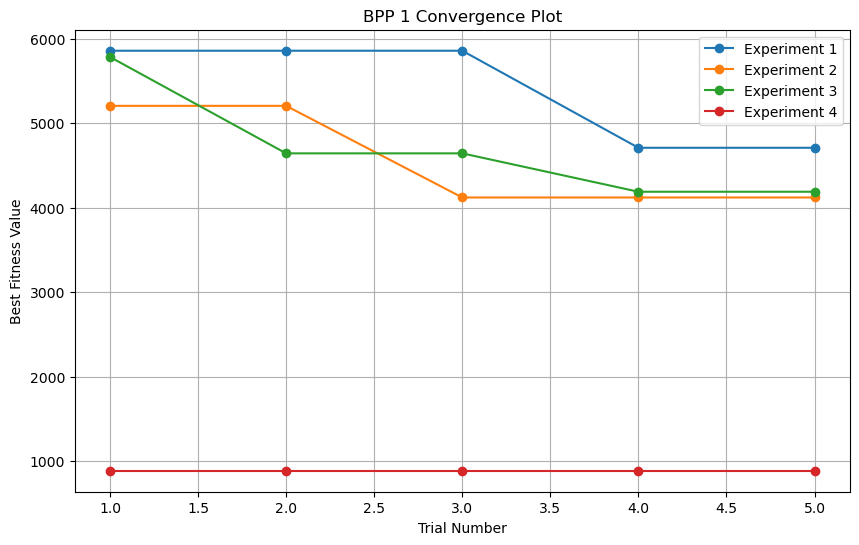

In [ ]:
import matplotlib.pyplot as plt

def convergence_plot(experiment_results):
    plt.figure(figsize=(10, 6))

    for experiment_num, best_fitness_per_trial in enumerate(experiment_results, start=1):
        plt.plot(range(1, len(best_fitness_per_trial) + 1), best_fitness_per_trial, marker='o', label=f'Experiment {experiment_num}')

    plt.xlabel('Trial Number')
    plt.ylabel('Best Fitness Value')
    plt.title('BPP 1 Convergence Plot')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage:
experiment1_results = [5856,5856,5856,4708,4708]
experiment2_results = [5204,5204,4120,4120,4120]
experiment3_results = [5782,4642,4642,4188,4188]
experiment4_results = [888,888,888,888,888]

all_experiment_results = [experiment1_results, experiment2_results, experiment3_results, experiment4_results]

convergence_plot(all_experiment_results)